# 카메라 스티커앱 만들기

## Step 1. 스티커 구하기 or 만들기

In [1]:
# 필요한 패키지 import 하기
import os # 환경 변수나 디렉터리, 파일 등의 OS 자원을 제어할 수 있게 해주는 모듈
import cv2 # OpenCV라이브러리 → 컴퓨터 비전 관련 프로그래밍을 쉽게 할 수 있도록 도와주는 라이브러리
import matplotlib.pyplot as plt # 다양한 데이터를 많은 방법으로 도식화 할 수 있도록 하는 라이브러리
import pandas as pd # 데이터분석 라이브러리
import numpy as np # 다차원 배열을 쉽게 처리하고 효율적으로 사용할 수 있도록 하는 라이브러리
import dlib # 이미지 처리 및 기계 학습, 얼굴인식 등을 할 수 있는 c++ 로 개발된 고성능의 라이브러리 
import math

ModuleNotFoundError: No module named 'cv2'

## 경로 설정

In [ ]:
now_dir = os.getcwd()
my_image_path = os.path.join(now_dir,'images/input_images/')  # 얼굴이미지가 있는 경로
model_path = os.path.join(now_dir,'models/shape_predictor_68_face_landmarks.dat')  # 모델의 weight file 경로를 가지고 온다.
sticker_path = os.path.join(now_dir,'images/cat-whiskers.png')  # 스티커 이미지의 경로
# save_file = my_image_path[:-4]+'_sticker.jpg' # 원본 이미지의 이름뒤에 _sticker추가후 저장

* opencv는 BGR(파랑, 초록, 빨강)의 이미지 채널을 사용하기 때문에 불러온 후 변경하여 봐야 한다.

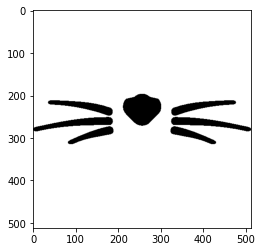

In [ ]:
sticker_image = cv2.imread(sticker_path)
plt.imshow(cv2.cvtColor(sticker_image, cv2.COLOR_BGR2RGB))
plt.show()

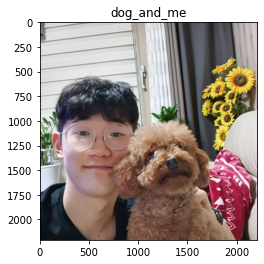

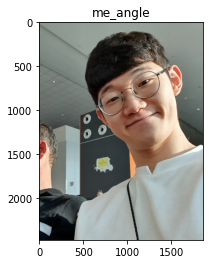

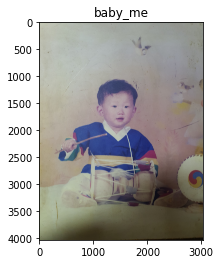

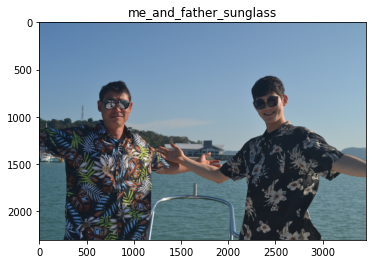

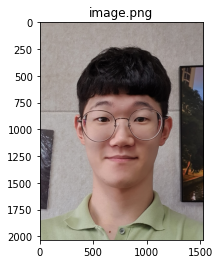

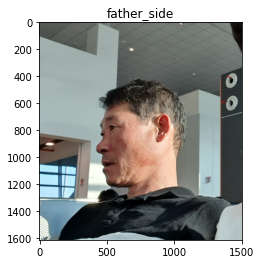

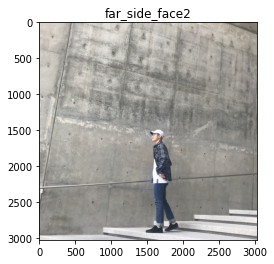

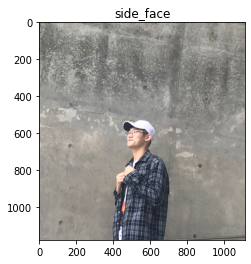

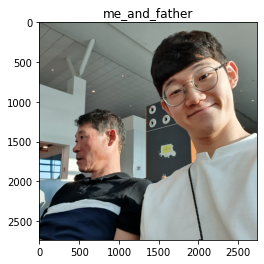

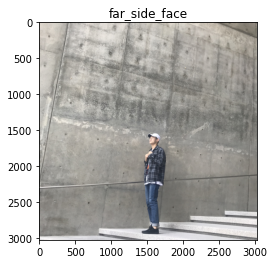

In [ ]:
# 이미지들 저장
images = {}
for img_name in os.listdir(my_image_path):
    if img_name == '.ipynb_checkpoints': # 주피터 노트북에서 자동저장을 위해 사용되는 폴더 삭제.
        os.rmdir(my_image_path + img_name)
    image_path = my_image_path + img_name
    face_image = cv2.imread(image_path)
    images[img_name[:-4]] = face_image
    
    plt.imshow(cv2.cvtColor(face_image, cv2.COLOR_BGR2RGB))
    plt.title(img_name[:-4])
    plt.show()
origin_images = images.copy()

## Step 2. 얼굴 검출 & 랜드마크 검출 하기

### 얼굴 검출하기


* dlib의 face detector는 HOG(Histogram of Oriented Gradients)와 SVM(Support Vector Machine)을 사용해 얼굴을 찾는다.
* `detector_hog`의 두번째 파라미터는 이미지 피라미드의 수이다.
* 이미지 파라미드는 Upsampling을 이용하여 크기를 키우는 것이다.

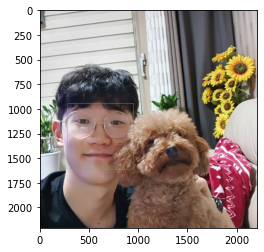

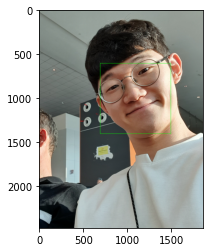

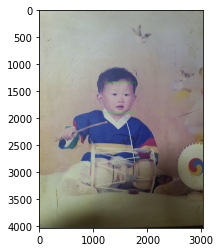

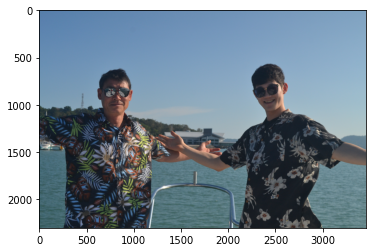

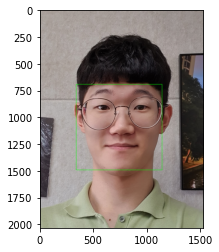

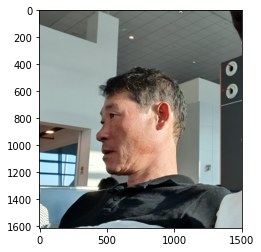

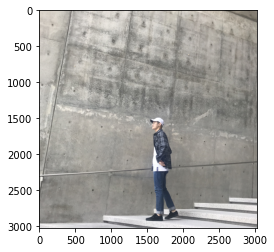

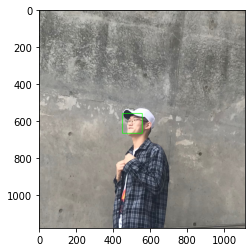

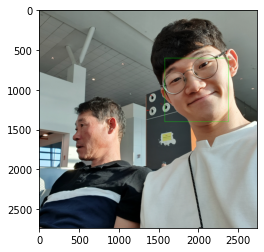

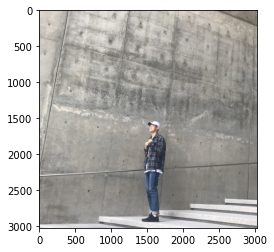

In [ ]:
save_rects = {}
for img_name,img in images.items():
    detector_hog = dlib.get_frontal_face_detector() # 기본 얼굴 감지기를 반환
    dlib_rects = detector_hog(cv2.cvtColor(img, cv2.COLOR_BGR2RGB), 1)   # (image, num of image pyramid)
    save_rects[img_name] = dlib_rects
    
    for dlib_rect in dlib_rects: # 찾은 얼굴 영역의 사각형 좌표        
        cv2.rectangle(img, (dlib_rect.left(),dlib_rect.top()), \
                      (dlib_rect.right(),dlib_rect.bottom()), (0,255,0), 2, lineType=cv2.LINE_AA) 
    images[img_name] = img
    plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    plt.show()

### Face landmark 설정하기

* Object keypoint estimation 알고리즘
    1. top-down : bounding box를 찾고 box 내부의 keypoint 예측
    2. bottom-up : 이미지 전체의 keypoint를 먼저 찾고 point 관계를 이용해 군집화 해서 box 생성
    
> 아래 예제는 1번 방식 사용

![face_landmark](https://d3s0tskafalll9.cloudfront.net/media/original_images/E-8-8.png)   

점의 개수는 데이터셋과 논문마다 다르다. 사용할 dilb는 [ibug 300-W 데이터셋](https://ibug.doc.ic.ac.uk/resources/facial-point-annotations/)으로 regression tree의 앙상블 모델을 사용하여 학습했고, 점의 개수는 위 사진처럼 68개를 사용한다.

* dlib의 shape_predictor 함수를 이용하여 모델을 불러옴
* landmark_predictor는 RGB이미지와 내부를 예측하는 박스(dlib.rectangle)를 입력 받고 구성 요소의 위치와, 이미지 상의 객체의 위치(dlib.full_object_detection)를 반환


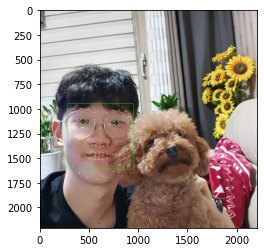

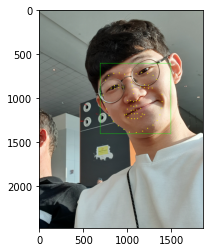

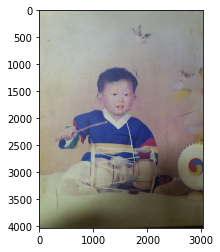

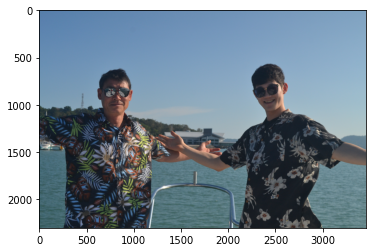

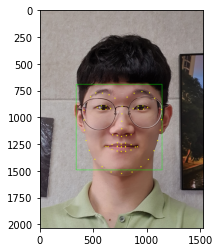

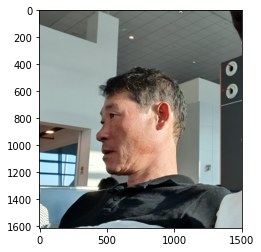

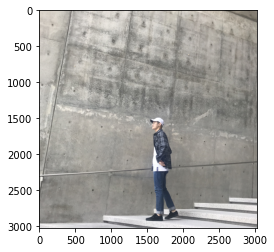

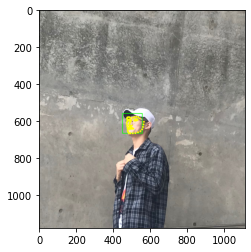

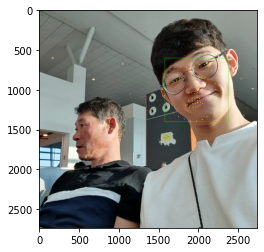

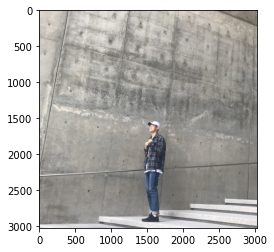

In [ ]:
landmark_predictor = dlib.shape_predictor(model_path) # 저장한 weigt file로 모델을 불러온다.
landmark_data = {}
for img_name,img in images.items():

    list_landmarks = []
    # dlib_rects는 얼굴 죄표값을 반환 얼굴이 2개 추정되면 for문 2번
    for dlib_rect in save_rects[img_name]:
        points = landmark_predictor(img, dlib_rect) # 모든 landmark의 위치정보를 points 변수에 저장

        list_points = list(map(lambda p: (p.x, p.y), points.parts())) # 위 사진의 점들을 의미
            # 각각의 landmark 위치정보를 (x,y) 형태로 변환하여 list_points 리스트로 저장

        list_landmarks.append(list_points)
    landmark_data[img_name] = list_landmarks
    
    for landmark in list_landmarks:
        for point in landmark:
            cv2.circle(img, point, 5, (0, 255, 255), -1)
            
    images[img_name] = img
    plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    plt.show()

## Step 3_4. 스티커 적용 위치 확인하고 적용하기

* zip() : 두 그룹의 데이터를 서로 엮어주는 파이썬의 내장 함수
* dlib_rects와 list_landmarks 데이터를 엮어 주었음
* dlib_rects : 얼굴 영역을 저장하고 있는 값
*list_landmarks : 68개의 랜드마크 값 저장(이목구비 위치(x,y))

* sticker_area는 원본 이미지에서 스티커를 적용할 위치를 미리 잘라낸 이미지입니다.
* np.where는 조건에 해당하는 인덱스만 찾아서 값을 적용하는 방법이다.

In [ ]:
img_Transparency = 0.7
result = {}
for image_name in os.listdir(my_image_path):
    img = cv2.imread(my_image_path + image_name)
    print(image_name)
    for dlib_rect, landmark in zip(save_rects[image_name[:-4]], landmark_data[image_name[:-4]]):
    #     w = h = dlib_rect.width() # 얼굴 영역의 가로를 차지하는 픽셀의 수
        w = h = (landmark[35][0] - landmark[31][0])*7 # 코의 좌우 크기를 비율로 사이즈 조절    
        x = landmark[30][0] - w//2 # 이미지에서 코 부위의 x값
        y = (landmark[30][1]+landmark[33][1])//2 - h//2  # 이미지에서 코 부위의 y값

          # 스티커가 원본사진을 넘어가면 잘라냄
        if x < 0:
            sticker_image = sticker_image[:, -x:]
            x = 0
        if y < 0:
            sticker_image = sticker_image[-y:, :]
            y = 0
        
        sticker_image = cv2.resize(sticker_image, (w,h)) # 스티커 이미지 조정
        
          # 스티커 부착할 영역을 선택하고 투명도를 조절후 부착
        sticker_area = img[y:y+sticker_image.shape[0], x:x+sticker_image.shape[1]]
        add_W_sticker = cv2.addWeighted(sticker_area, 1-img_Transparency, sticker_image, img_Transparency, 0)
        
        img[y:y+sticker_image.shape[0], x:x+sticker_image.shape[1]] = \
        np.where(sticker_image!=0,sticker_area,add_W_sticker).astype(np.uint8)
        
        result[image_name[:-4]] = img


dog_and_me.jpg
me_angle.jpg
baby_me.jpg
me_and_father_sunglass.jpg
image.png.jpg
father_side.jpg
far_side_face2.jpg
side_face.jpg
me_and_father.jpg
far_side_face.jpg


* 이미지의 시작점은 top-left 이기 때문에 400,400을 코로 생각하고 다음과 같이 시작점 설정
* 스티커 이미지가 얼굴이미지 밖에서 시작하지 않도록 조정
* 좌표 순서가 y,x임에 유의한다. (y,x,rgb channel)

In [ ]:
# if input("이미지를 저장하시겠습니까? y/n : ") == 'y':    
#     save_file = my_image_path[:-4]+'_sticker.jpg'
#     cv2.imwrite(save_file, img_show)
#     print(save_file,"  에 저장되었습니다.")

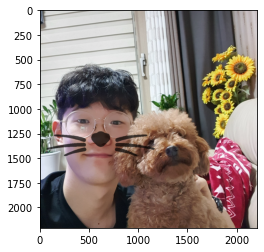

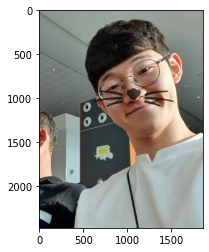

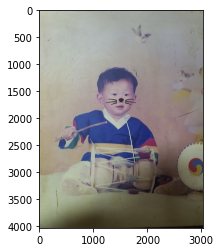

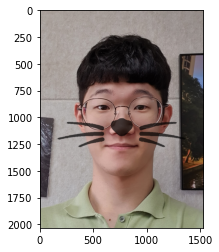

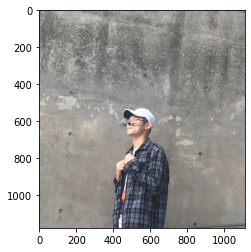

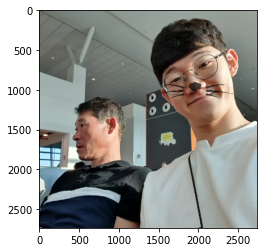

In [ ]:
for img in result.values():    
    
    plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    plt.show()

## Step 5. 문제점 찾아보기

### 위 내용을 정리함

In [ ]:
def My_sticker_app(image,img_sticker,landmark_predictor,img_Transparency = 0.7, hog_pypamid = 1):
    img = image.copy()
    # face detector
    detector_hog = dlib.get_frontal_face_detector() # 기본 얼굴 감지기를 반환
    dlib_rects = detector_hog(cv2.cvtColor(img, cv2.COLOR_BGR2RGB), hog_pypamid)   # (image, num of image pyramid)

    # landmark detector
    list_landmarks = []
    for dlib_rect in dlib_rects:
        points = landmark_predictor(img, dlib_rect) # 모든 landmark의 위치정보를 points 변수에 저장
        list_points = list(map(lambda p: (p.x, p.y), points.parts())) # 위 사진의 점들을 의미
        list_landmarks.append(list_points)  # list_landmarks에 랜드마크 리스트를 저장

    list_stickers_point = []
    for dlib_rect, landmark in zip(dlib_rects, list_landmarks):
        w = h = (landmark[35][0] - landmark[31][0])*7 # 코의 좌우 크기를 비율로 스티커 이미지 사이즈 조절
        
        x = landmark[30][0] - w//2  # 이미지에서 코 부위의 x값
        y = (landmark[30][1]+landmark[33][1])//2 - w//2  # 이미지에서 코 부위의 y값
        
        # 고양이 수염의 각도 조정
        dy = landmark[8][1] - landmark[27][1]
        dx = landmark[8][0] - landmark[27][0]
        sticker_angle = math.atan2(dx, dy) * (180.0 / math.pi)
        
        # 회전 행렬 생성후 회전
        img_center = tuple((img_sticker.shape[0]/2,img_sticker.shape[1]/2))
        rot_mat = cv2.getRotationMatrix2D(img_center, sticker_angle, 1.0) 
        img_sticker = cv2.warpAffine(img_sticker, rot_mat, img_sticker.shape[1::-1], flags=cv2.INTER_LINEAR,borderValue=(255,255,255))
        
        # 스티커가 원본사진을 넘어가면 잘라냄
        if x < 0: 
            img_sticker = img_sticker[:, -x:]
            x = 0
        if y < 0:
            img_sticker = img_sticker[-y:, :]
            y = 0

        img_sticker = cv2.resize(img_sticker, (w,h)) # 스티커 이미지 조정
        # 스티커 부착할 영역을 선택하고 투명도를 조절후 부착
        sticker_area = img[y:y+img_sticker.shape[0], x:x+img_sticker.shape[1]]
        add_W_sticker = cv2.addWeighted(sticker_area, 1-img_Transparency, img_sticker, img_Transparency, 0)
        img[y:y+img_sticker.shape[0], x:x+img_sticker.shape[1]] = \
        np.where(img_sticker!=0,sticker_area,add_W_sticker).astype(np.uint8)
        
        return img

## 첫 시도
 * 처음 세 이미지는 정면인 얼굴에 비교적 이목구비가 선명하게 나와있어 잘 나왔다.   
 * 다음엔 각도를 다르게 찍어 확인해보자.

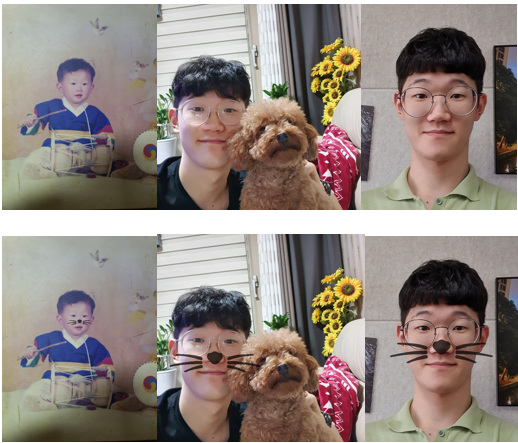

### 두 사람 / 정면과 측면
* 측면을 인식하지 못했고 정면의 이미지 또한 기울어져 있어 오른쪽 부분을 제대로 인식하지 못함.

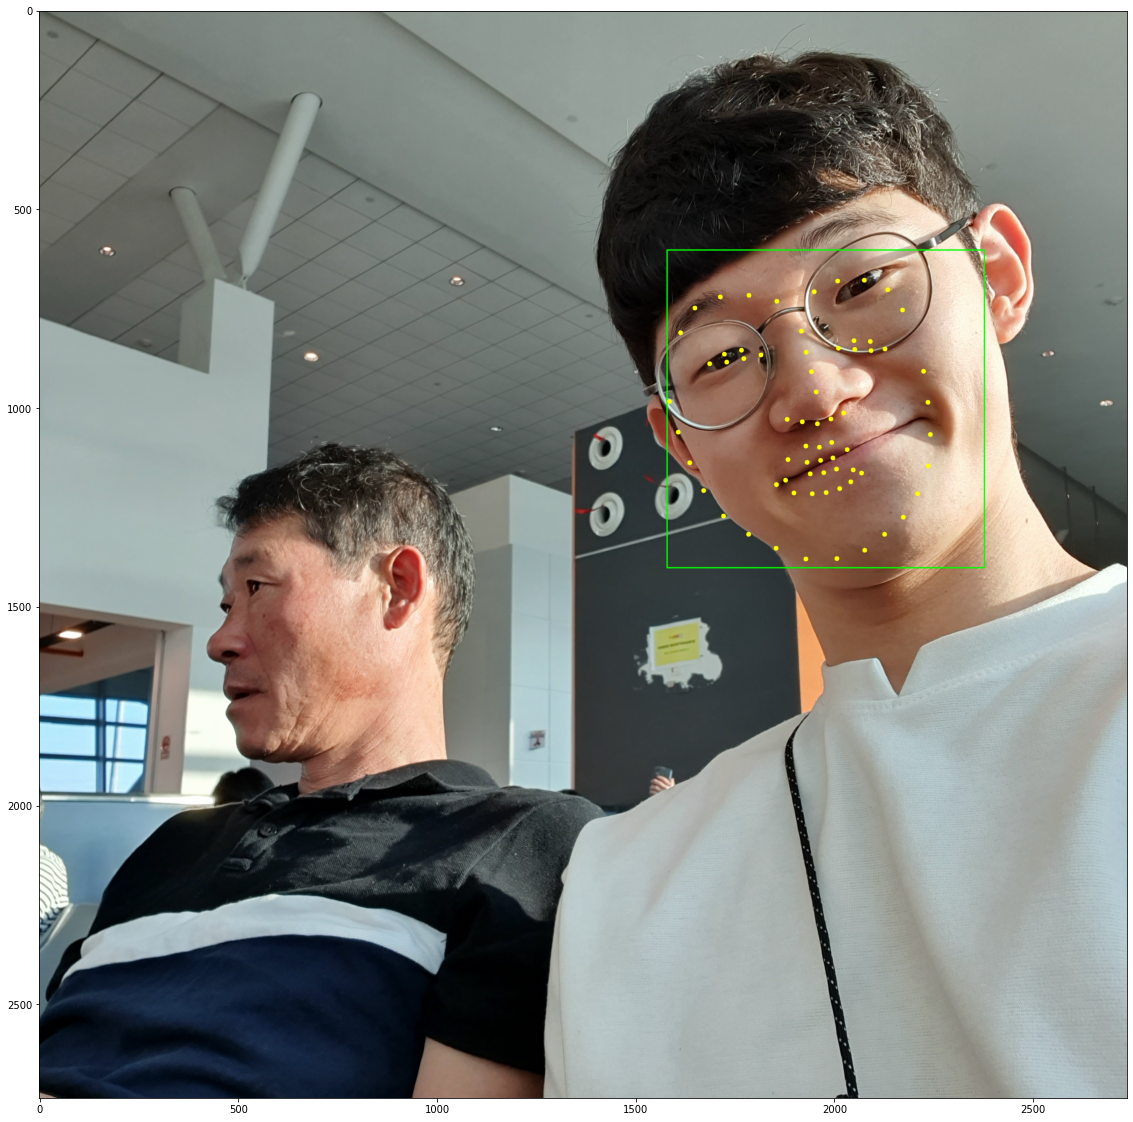    

In [ ]:
now_dir = os.getcwd()
my_image_path = os.path.join(now_dir,'images/input_images/')  # 얼굴이미지가 있는 경로
model_path = os.path.join(now_dir,'models/shape_predictor_68_face_landmarks.dat')  # 모델의 weight file 경로를 가지고 온다.
sticker_path = os.path.join(now_dir,'images/cat-whiskers.png')  # 스티커 이미지의 경로

landmark_predictor = dlib.shape_predictor(model_path) # 저장한 weigt file로 모델을 불러온다.
img_sticker = cv2.imread(sticker_path) # OpenCV로 이미지를 불러옵니다


* 얼굴의 우측 빛으로 인하여 landmark를 잘 못잡는것 같음.
* 또한 정 우측 방향의 얼굴 또한 힘들어 보임

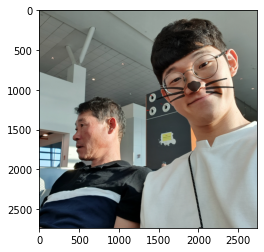

In [ ]:
img = cv2.imread(my_image_path+'me_and_father.jpg') # OpenCV로 이미지를 불러옵니다
result = My_sticker_app(img,img_sticker,landmark_predictor,img_Transparency = 0.7, hog_pypamid = 1)

plt.imshow(cv2.cvtColor(result, cv2.COLOR_BGR2RGB))
plt.show()

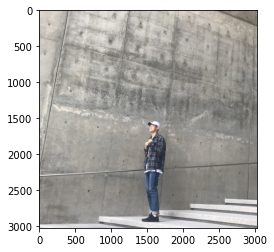

In [ ]:
img = cv2.imread(my_image_path+'far_side_face.jpg') # OpenCV로 이미지를 불러옵니다
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
plt.show()

# result = My_sticker_app(img,img_sticker,landmark_predictor,img_Transparency = 0.7, hog_pypamid = 3)

# plt.imshow(cv2.cvtColor(result, cv2.COLOR_BGR2RGB))
# plt.show()

* 너무 멀리 있는 얼굴 또한 못찾는다.

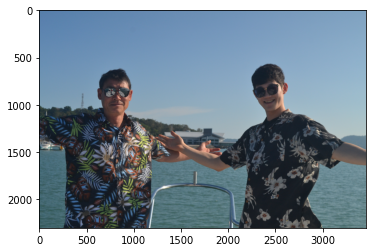

In [ ]:
img = cv2.imread(my_image_path+'me_and_father_sunglass.jpg') # OpenCV로 이미지를 불러옵니다
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
plt.show()


* 썬글라스를 쓰고 있어도..

In [ ]:
## CNN 모델의 검출기가 있다. 현재 환경에서는 kernel appears to have died. 커널이 죽는 문제?로 불가.
# cnn_model_path = os.path.join(now_dir,'models/mmod_human_face_detector.dat') 
# cnn_face_detector = dlib.cnn_face_detection_model_v1(cnn_model_path)
# face_detections = cnn_face_detector(img_rgb, 1)
# face_detections

CNN을 이용하면 더욱 성능이 좋아진다.